In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request
import json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.1


In [2]:
# ====================== Loading Data from Alpha Vantage ==================================
data_source = 'alphavantage'  # alphavantage or kaggle

if data_source == 'alphavantage':
    api_key = 'XDURUQNJ0FWF70J4'
    ticker = "AAL"  # American Airlines stock market prices
    
    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&outputsize=full&apikey={api_key}"
    
    # Save data to this file
    file_to_save = f'stock_market_data-{ticker}.csv'
    
    # If you haven't already saved data, grab the data from the url
    if not os.path.exists(file_to_save):
        print("Downloading data from Alpha Vantage...")
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            
            # Check if we got valid data
            if 'Time Series (Daily)' not in data:
                print("Error: Could not fetch data. Using sample data instead.")
                # Create sample data for demonstration
                dates = pd.date_range(start='2020-01-01', end='2024-01-01', freq='D')
                np.random.seed(42)
                prices = 20 + np.cumsum(np.random.randn(len(dates)) * 0.1)
                df = pd.DataFrame({
                    'Date': dates,
                    'Open': prices + np.random.randn(len(dates)) * 0.1,
                    'High': prices + np.abs(np.random.randn(len(dates)) * 0.2),
                    'Low': prices - np.abs(np.random.randn(len(dates)) * 0.2),
                    'Close': prices + np.random.randn(len(dates)) * 0.1
                })
                df = df[df['Date'].dt.dayofweek < 5]  # Remove weekends
            else:
                # Extract stock market data
                data = data['Time Series (Daily)']
                df = pd.DataFrame(columns=['Date', 'Low', 'High', 'Close', 'Open'])
                
                for k, v in data.items():
                    date = dt.datetime.strptime(k, '%Y-%m-%d')
                    data_row = [
                        date.date(),
                        float(v['3. low']),
                        float(v['2. high']),
                        float(v['4. close']),
                        float(v['1. open'])
                    ]
                    df.loc[len(df)] = data_row
                
        print(f'Data saved to: {file_to_save}')
        df.to_csv(file_to_save, index=False)
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)
        df['Date'] = pd.to_datetime(df['Date'])

else:
    # Loading Data from Kaggle (if you have the data file)
    df = pd.read_csv(os.path.join('Stocks', 'hpq.us.txt'), 
                     delimiter=',', 
                     usecols=['Date', 'Open', 'High', 'Low', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'])
    print('Loaded data from the Kaggle repository')

# Sort DataFrame by date
df = df.sort_values('Date').reset_index(drop=True)
print(f"Data shape: {df.shape}")
print("First few rows:")
print(df.head())


Data saved to: stock_market_data-AAL.csv
Data shape: (5014, 5)
First few rows:
         Date    Low   High  Close   Open
0  2005-09-27  19.10  21.40  19.30  21.05
1  2005-09-28  19.20  20.53  20.50  19.30
2  2005-09-29  20.10  20.58  20.21  20.40
3  2005-09-30  20.18  21.05  21.01  20.26
4  2005-10-03  20.90  21.75  21.50  20.90


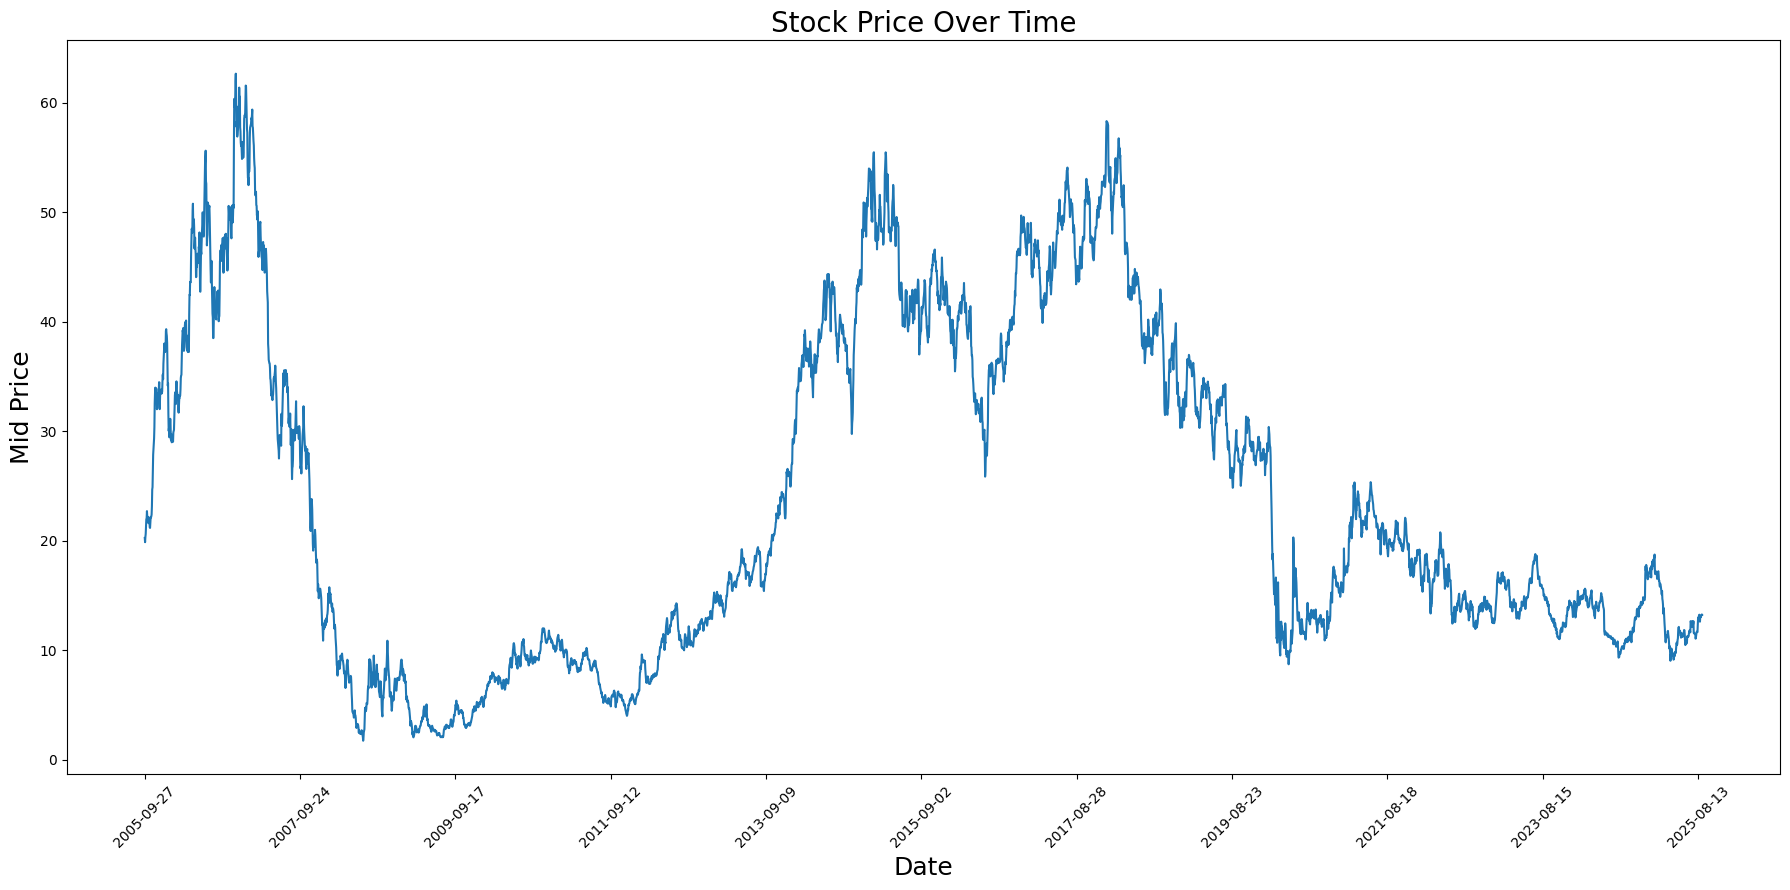

In [3]:
# Plot the data
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High']) / 2.0)
plt.xticks(range(0, df.shape[0], 500), 
           [df['Date'].iloc[i].strftime('%Y-%m-%d') if i < len(df) else '' 
            for i in range(0, df.shape[0], 500)], 
           rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.title('Stock Price Over Time', fontsize=20)
plt.tight_layout()
plt.show()


In [4]:
# Calculate mid prices from the highest and lowest
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices + low_prices) / 2.0

print(f"Total data points: {len(mid_prices)}")

Total data points: 5014


In [5]:
# Split the data (90% for training)
split_index = int(len(mid_prices) * 0.9)
train_data = mid_prices[:split_index]
test_data = mid_prices[split_index:]

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (4512,)
Test data shape: (502,)


In [6]:
# Scale the data to be between 0 and 1
# Normalize both test and train data with respect to training data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Train the Scaler with training data and smooth data
smoothing_window_size = min(2500, len(train_data))

In [7]:
# Fit scaler on entire training data
scaler.fit(train_data)
train_data = scaler.transform(train_data)

# Reshape train data back to 1D
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [8]:
# Exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Combine all data
all_mid_data = np.concatenate([train_data, test_data], axis=0)

print("Data preprocessing completed")

Data preprocessing completed


# One-Step Ahead Prediction via Averaging

## Standard Average

In [9]:
window_size = 100
N = train_data.size
std_avg_predictions = []
mse_errors = []

for pred_idx in range(window_size, N):
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx])**2)

print('MSE error for standard averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.00234


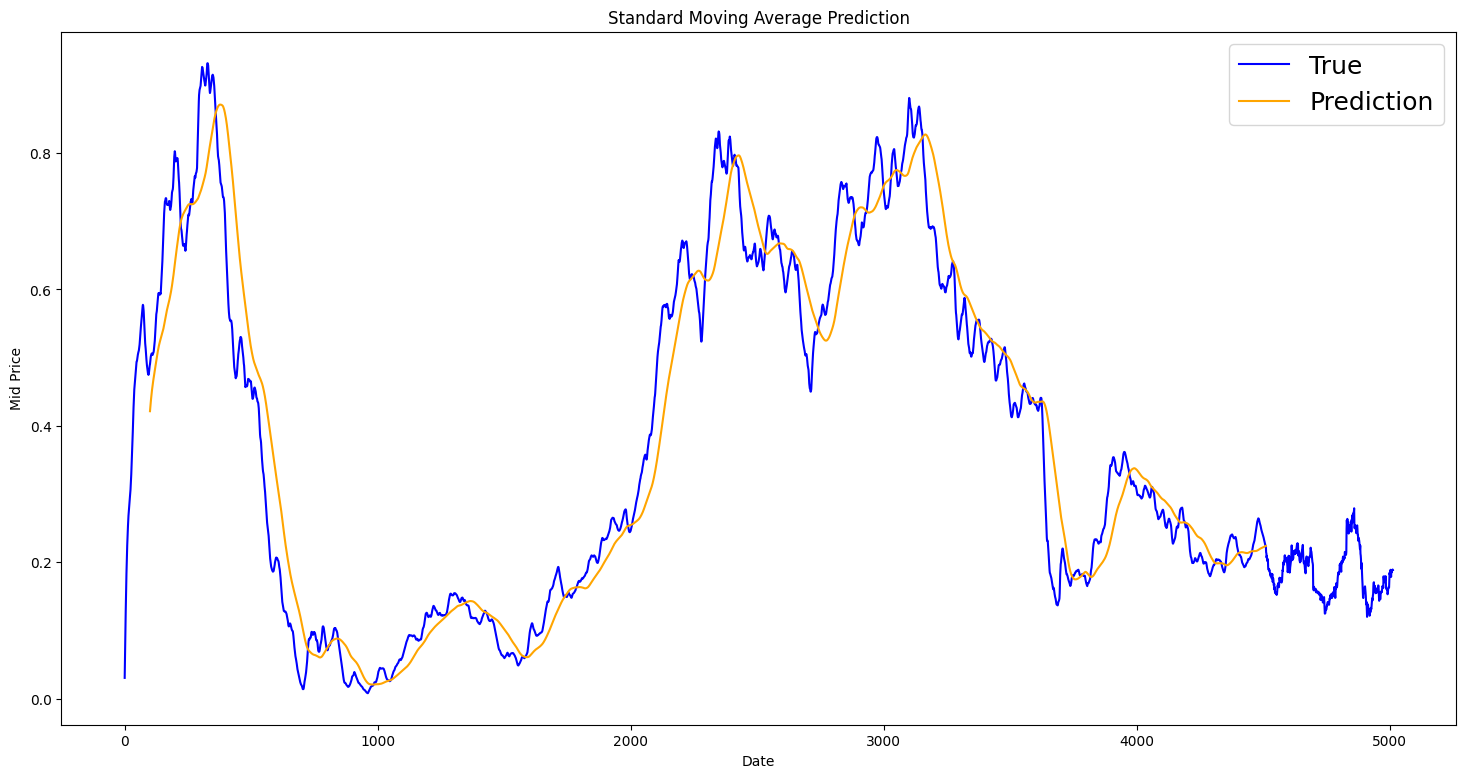

In [10]:
# Plot standard average predictions
plt.figure(figsize=(18, 9))
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True')
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.title('Standard Moving Average Prediction')
plt.legend(fontsize=18)
plt.show()

## Exponential Moving Average

In [11]:
# Exponential Moving Average
run_avg_predictions = []
mse_errors = []
running_mean = 0.0
decay = 0.5

run_avg_predictions.append(running_mean)

for pred_idx in range(1, N):
    running_mean = running_mean * decay + (1.0 - decay) * train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx])**2)

print('MSE error for EMA averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for EMA averaging: 0.00002


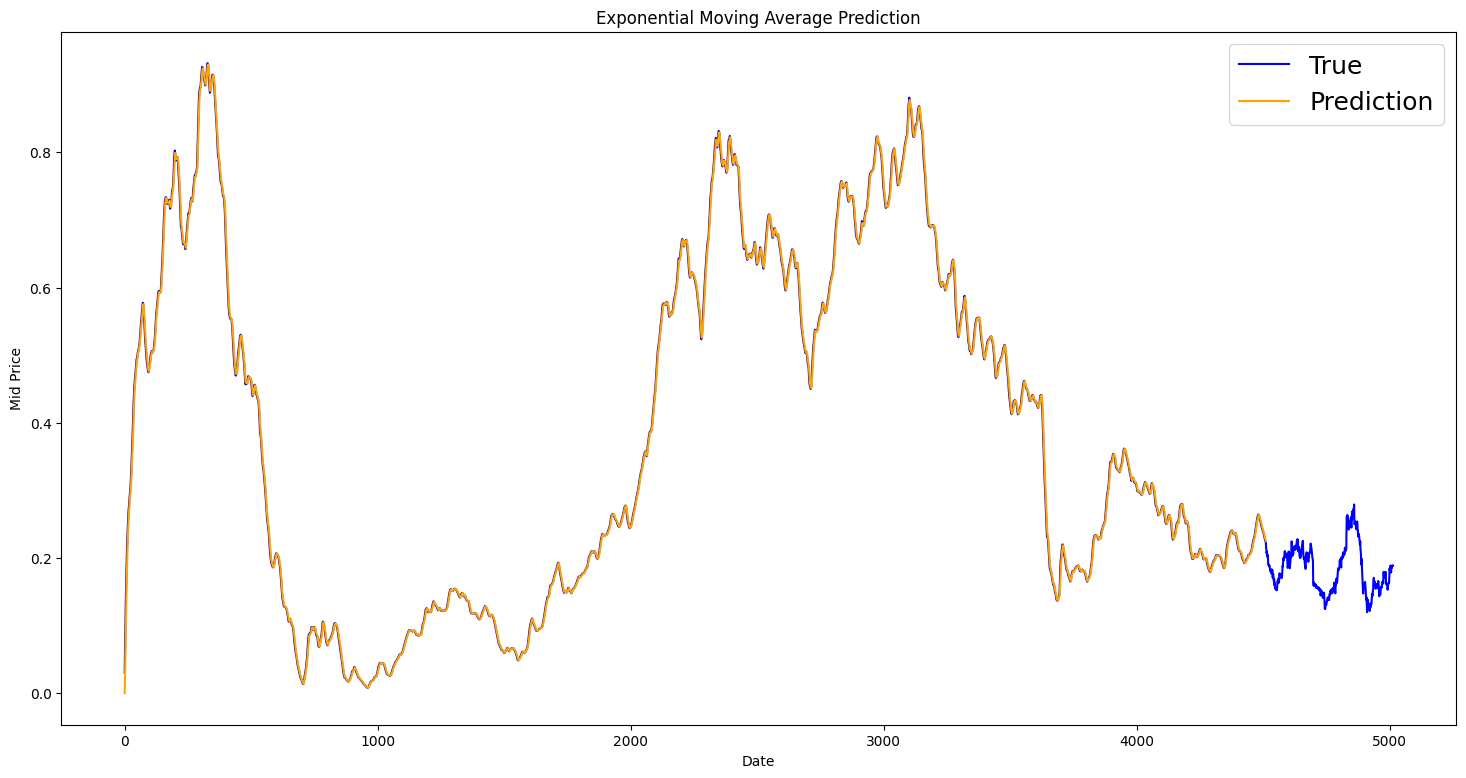

In [12]:
# Plot EMA predictions
plt.figure(figsize=(18, 9))
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True')
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.title('Exponential Moving Average Prediction')
plt.legend(fontsize=18)
plt.show()

## Predict more than one step into the future

To make things concrete, let's assume values:  
$x_t = 0.4$, $EMA = 0.5$, and $\gamma = 0.5$  

Say you get the output with the following equation:  

\[
X_{t+1} = EMA_t = \gamma \times EMA_{t-1} + (1 - \gamma) X_t
\]

So you have:  

\[
x_{t+1} = 0.5 \times 0.5 + (1 - 0.5) \times 0.4 = 0.45
\]

Thus,  

\[
X_{t+1} = EMA_t = 0.45
\]

---

Now, the next prediction $X_{t+2}$ becomes:  

\[
X_{t+2} = \gamma \times EMA_t + (1 - \gamma) X_{t+1}
\]

Which simplifies to:  

\[
X_{t+2} = \gamma \times EMA_t + (1 - \gamma) EMA_t = EMA_t
\]

Or in this example:  

\[
X_{t+2} = X_{t+1} = 0.45
\]

So, no matter how many steps you predict in the future, you'll keep getting the same answer for all the future prediction steps.

---

### A Better Solution

One solution that will output useful information is to look at **momentum-based algorithms**.  
They make predictions based on whether the past recent values were going **up or down** (not the exact values).  

For example:  
- If prices have been dropping for the past few days → the next-day price will likely be **lower**.  

This is more reasonable. However, in practice, you would use a more complex model: an **LSTM model**.

---

### Why LSTMs?

LSTM models have taken the realm of **time series prediction** by storm because they are so good at modeling sequential data.  

They can reveal whether there are **hidden patterns** in the data that you can exploit for better predictions.


In [13]:
class DataGeneratorSeq(object):
    def __init__(self, prices, batch_size, num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length // self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        batch_data = np.zeros((self._batch_size,), dtype=np.float32)
        batch_labels = np.zeros((self._batch_size,), dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b] + 1 >= self._prices_length:
                self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(1, 5)]
            self._cursor[b] = (self._cursor[b] + 1) % self._prices_length

        return batch_data, batch_labels

    def unroll_batches(self):
        unroll_data, unroll_labels = [], []
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0, min((b + 1) * self._segments, self._prices_length - 1))

# Test data generator
print("Testing data generator...")
dg = DataGeneratorSeq(train_data, 5, 5)
u_data, u_labels = dg.unroll_batches()

for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
    print(f'\nUnrolled index {ui}')
    print('\tInputs: ', dat)
    print('\tOutput:', lbl)

Testing data generator...

Unrolled index 0
	Inputs:  [0.03039658 0.03315518 0.17225309 0.4820983  0.42965493]
	Output: [0.05712127 0.03379469 0.17431147 0.45817098 0.42970708]

Unrolled index 1
	Inputs:  [0.05712127 0.03352634 0.17286175 0.4766342  0.42970708]
	Output: [0.12644066 0.03406084 0.17528906 0.46856353 0.4240475 ]

Unrolled index 2
	Inputs:  [0.08195353 0.03379469 0.17350808 0.46856353 0.4265508 ]
	Output: [0.1470177  0.03497367 0.17607036 0.45431745 0.42316505]

Unrolled index 3
	Inputs:  [0.10475415 0.03406084 0.17431147 0.46207172 0.4248638 ]
	Output: [0.12644066 0.03658345 0.17528906 0.45817098 0.42316505]

Unrolled index 4
	Inputs:  [0.12644066 0.03497367 0.17528906 0.45817098 0.4240475 ]
	Output: [0.19874156 0.0383689  0.17614378 0.4553131  0.42305115]


In [14]:
D = 1  # Dimensionality of the data
num_unrollings = 50  # Number of time steps you look into the future
batch_size = 500  # Number of samples in a batch
num_nodes = [200, 200, 150]  # Number of hidden nodes in each layer
n_layers = len(num_nodes)  # number of layers
dropout = 0.2  # dropout amount

print(f"Model parameters:")
print(f"- Input dimension: {D}")
print(f"- Sequence length: {num_unrollings}")
print(f"- Batch size: {batch_size}")
print(f"- LSTM layers: {num_nodes}")
print(f"- Dropout: {dropout}")

Model parameters:
- Input dimension: 1
- Sequence length: 50
- Batch size: 500
- LSTM layers: [200, 200, 150]
- Dropout: 0.2


In [32]:
def create_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(
            units=num_nodes[0],
            return_sequences=True,
            dropout=dropout,
            input_shape=(num_unrollings, D)
        ),
        tf.keras.layers.LSTM(
            units=num_nodes[1],
            return_sequences=True,
            dropout=dropout
        ),
        tf.keras.layers.LSTM(
            units=num_nodes[2],
            return_sequences=False,
            dropout=dropout
        ),
        tf.keras.layers.Dense(units=1)
    ])
    return model

# Create the model
model = create_lstm_model()

In [33]:
# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

print("Model compiled successfully")
model.summary()

Model compiled successfully


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,151 (2.64 MB)

 Trainable params: 693,151 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# ====================== Data Preparation for Training ======================

def prepare_training_data(data_generator, num_batches):
    """Prepare training data in the format expected by Keras"""
    X_train = []
    y_train = []
    
    for _ in range(num_batches):
        u_data, u_labels = data_generator.unroll_batches()
        
        # Convert list of arrays to proper format
        # u_data: list of num_unrollings arrays, each of shape (batch_size,)
        # Target: (batch_size, num_unrollings, 1)
        
        batch_x = np.array(u_data).T  # Shape: (batch_size, num_unrollings)
        batch_y = np.array(u_labels).T  # Shape: (batch_size, num_unrollings)
        
        # Add feature dimension
        batch_x = np.expand_dims(batch_x, axis=-1)  # Shape: (batch_size, num_unrollings, 1)
        batch_y = np.expand_dims(batch_y, axis=-1)  # Shape: (batch_size, num_unrollings, 1)
        
        X_train.append(batch_x)
        y_train.append(batch_y)
        
        # Reset indices to get different sequences
        data_generator.reset_indices()
    
    return np.vstack(X_train), np.vstack(y_train)

# Prepare training data
print("Preparing training data...")
train_seq_length = train_data.size
num_batches = max(1, train_seq_length // (batch_size * num_unrollings))
data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

X_train, y_train = prepare_training_data(data_gen, num_batches)
print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")

Preparing training data...
Training data shape: X=(500, 50, 1), y=(500, 50, 1)


In [46]:
# ====================== Model Training ======================

epochs = 30
print("Starting training...")

# Create callbacks (without ReduceLROnPlateau to avoid learning rate conflicts)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10, 
        restore_best_weights=True, 
        monitor='val_loss',
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size//4,  # Use smaller batches for training
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("Training finished.")

Starting training...
Epoch 1/30


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0302 - mae: 0.1160 - val_loss: 0.0061 - val_mae: 0.0710
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.0375 - mae: 0.1312 - val_loss: 0.0041 - val_mae: 0.0536
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0345 - mae: 0.1247 - val_loss: 0.0078 - val_mae: 0.0809
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0437 - mae: 0.1461 - val_loss: 0.0069 - val_mae: 0.0731
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.0416 - mae: 0.1516 - val_loss: 0.0117 - val_mae: 0.1003
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.0409 - mae: 0.1540 - val_loss: 0.0104 - val_mae: 0.0928
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.0338 - mae: 0.1394 - val_loss: 0.0090 - val_mae: 0.0849
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.0366 - mae: 0.1437 - val_loss: 0.0092 - val_mae: 0.0873
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.0330 - mae: 0.1348 - va

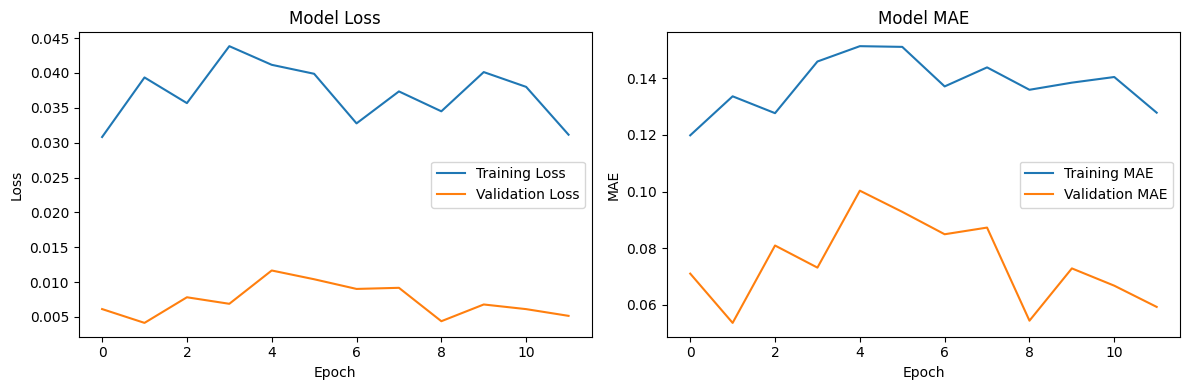

In [47]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

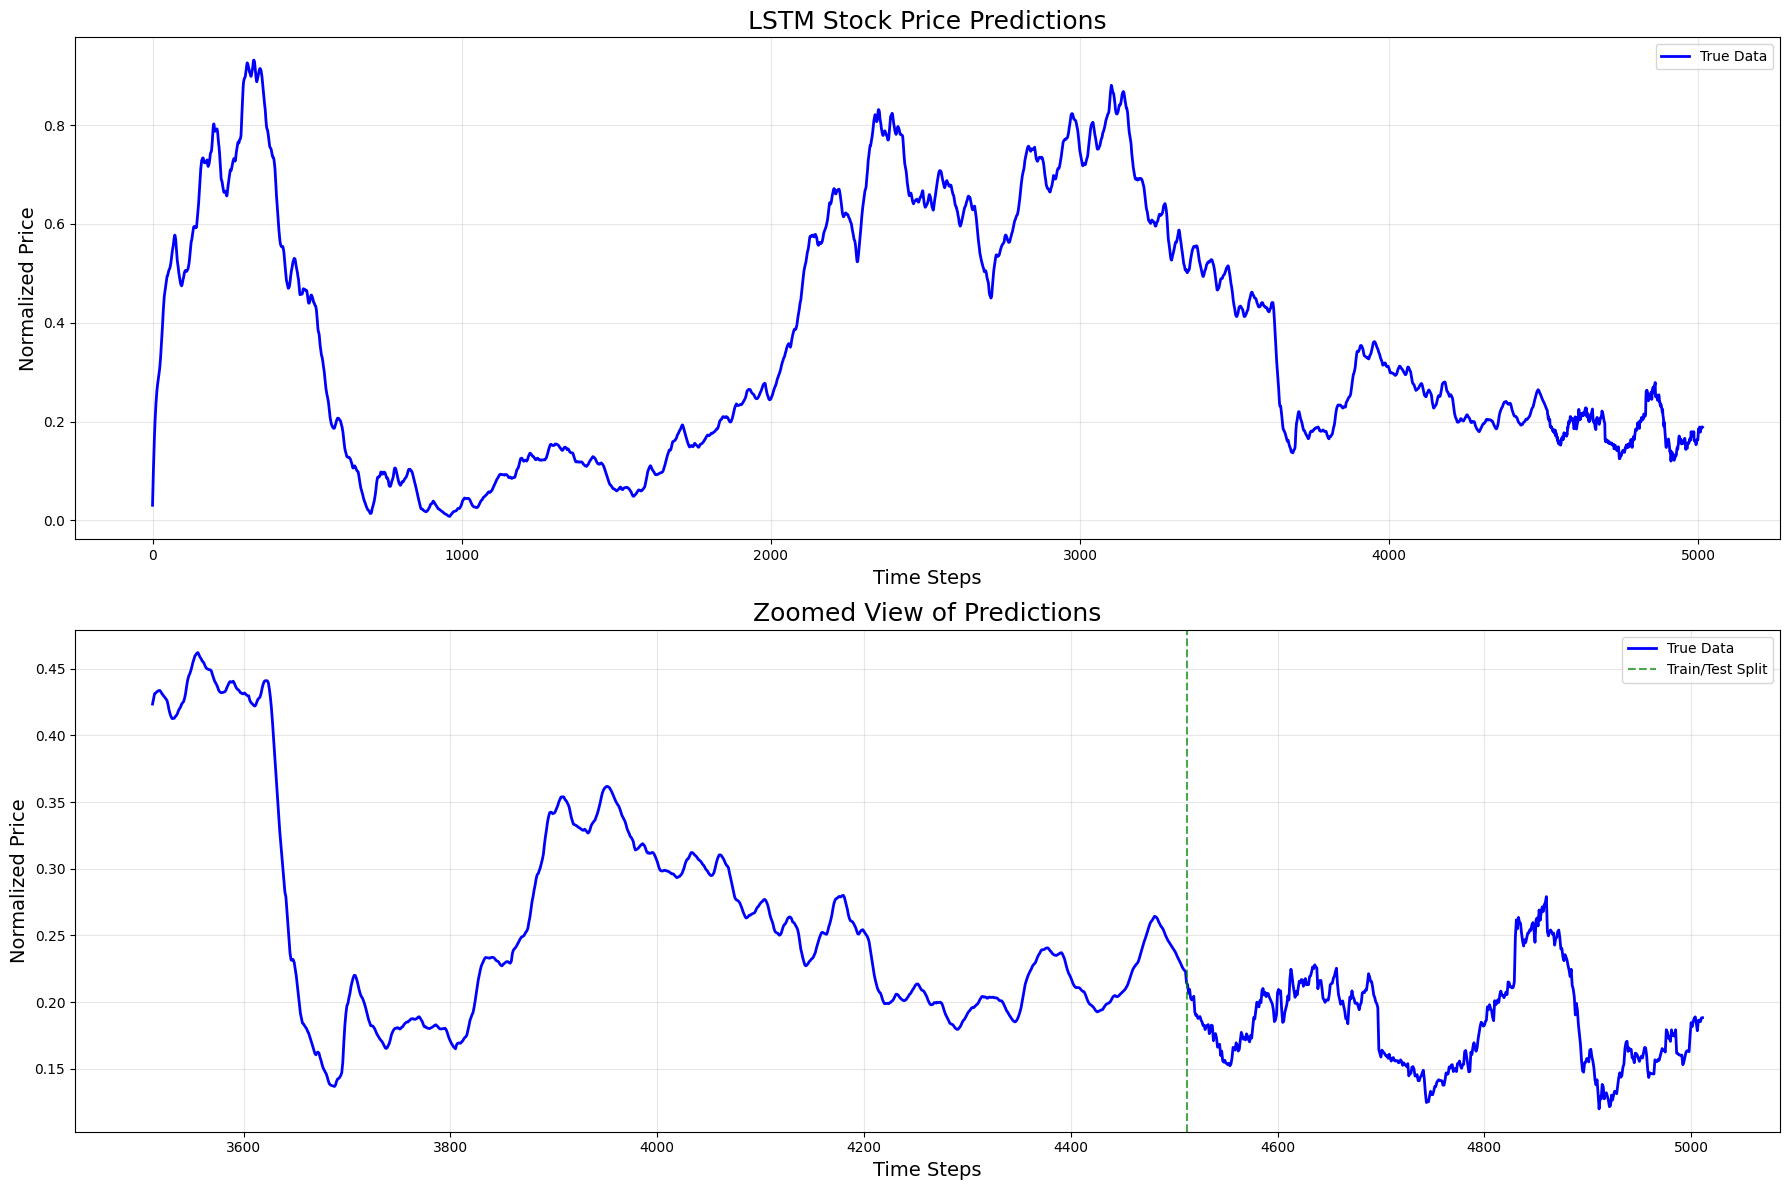


SUMMARY
Total data points: 5014
Training data points: 4512
Test data points: 502
Standard Moving Average MSE: 0.00002
Model saved as 'lstm_stock_model.h5'


In [50]:
# ====================== Final Plotting ======================

plt.figure(figsize=(18, 12))

# Plot 1: Full data with predictions
plt.subplot(2, 1, 1)
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True Data', linewidth=2)

for xval, yval in zip(x_axis_seq, predictions_seq):
    plt.plot(xval, yval, color='r', alpha=0.7, linewidth=1)

plt.title('LSTM Stock Price Predictions', fontsize=18)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Normalized Price', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed view
plt.subplot(2, 1, 2)
zoom_start = max(0, len(train_data) - 1000)
zoom_end = min(len(all_mid_data), len(train_data) + 500)

plt.plot(range(zoom_start, zoom_end), 
         all_mid_data[zoom_start:zoom_end], 
         color='b', label='True Data', linewidth=2)



plt.axvline(x=len(train_data), color='g', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.title('Zoomed View of Predictions', fontsize=18)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Normalized Price', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Total data points: {len(mid_prices)}")
print(f"Training data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")
print(f"Standard Moving Average MSE: {0.5 * np.mean(mse_errors):.5f}")
print("="*50)

# Save the model
model.save('lstm_stock_model.h5')
print("Model saved as 'lstm_stock_model.h5'")